# Chargement du dataset & Analyse exploratoire


In [1]:
pip install tensorflow matplotlib seaborn scikit-learn pandas

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kenzabaff","key":"8bfd809ec7dc55ddad785cb099b1164e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [6]:
!unzip -q intel-image-classification.zip -d intel_data

In [7]:
#création du dataset d'entrainement
import tensorflow as tf

train_dir = "intel_data/seg_train/seg_train"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32
)

Found 14034 files belonging to 6 classes.


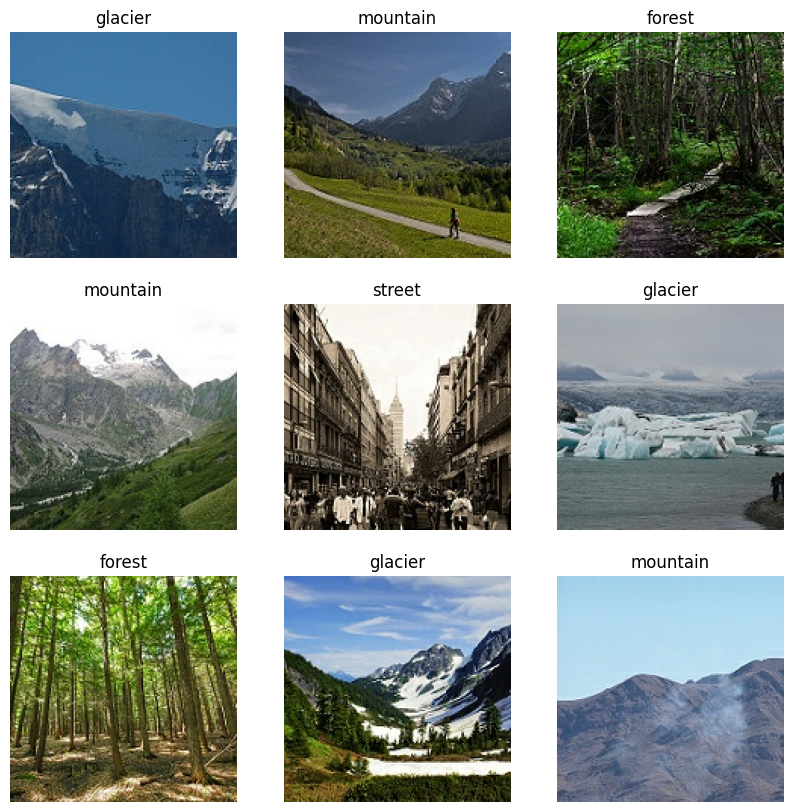

In [8]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy()
        plt.title(class_names[label_index])
        plt.axis("off")
plt.show()

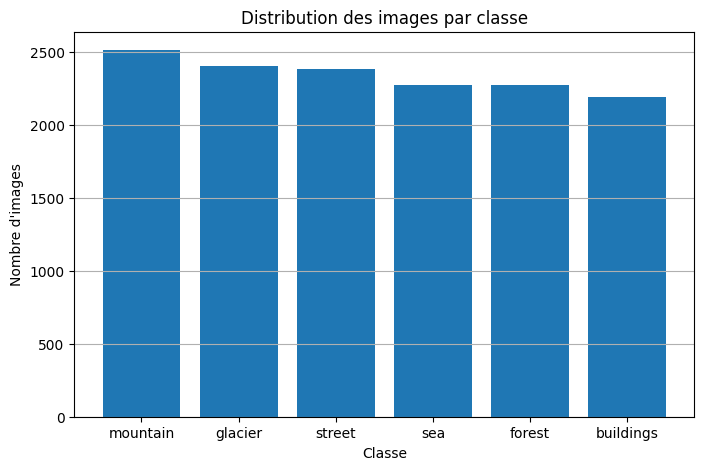

In [9]:
import pandas as pd
# Répertoire des images
train_path = "intel_data/seg_train/seg_train"

# Compter les images par classe
class_counts = {}
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Visualiser
df = pd.DataFrame(list(class_counts.items()), columns=["Classe", "Nombre d'images"])
df = df.sort_values(by="Nombre d'images", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df["Classe"], df["Nombre d'images"])
plt.title("Distribution des images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.grid(axis='y')
plt.show()

# Prétraitement / Augmentation : Normalisation, rotation, flip, zoom

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

# Pipeline de prétraitement + augmentation
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255),              # Normalisation des pixels
    layers.RandomFlip("horizontal"),       # Flip horizontal aléatoire
    layers.RandomRotation(0.1),            # Rotation légère
    layers.RandomZoom(0.1),                # Zoom aléatoire
])


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Bien que le dataset soit relativement équilibré, nous appliquons des techniques
# d'augmentation de données (flip, rotation, zoom) afin d'améliorer la robustesse du modèle et limiter le sur-apprentissage

In [14]:
test_path = "intel_data/seg_test/seg_test"

In [15]:
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(150, 150),
    batch_size=32
)

# Récupérer les noms de classes AVANT le map()
test_class_names = test_ds_raw.class_names

# Normaliser ensuite
test_ds = test_ds_raw.map(lambda x, y: (x / 255.0, y))


Found 3000 files belonging to 6 classes.


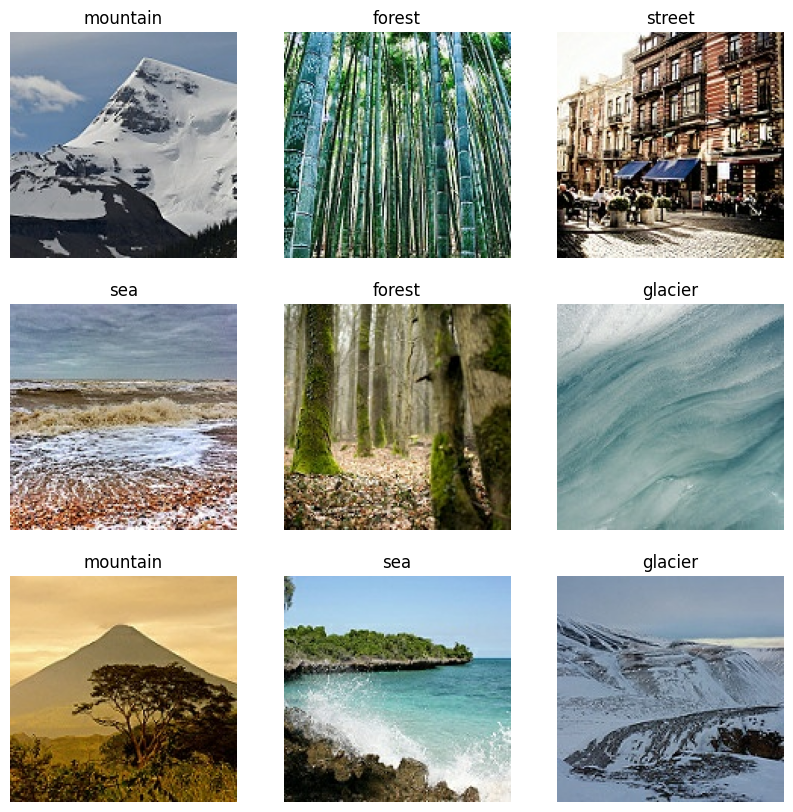

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(test_class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()


# Personnalisation d'un modèle

In [23]:
#construction d'un modèle CNN

from tensorflow.keras import layers, models

model = models.Sequential([
    # Normalisation
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),

    # Bloc 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Bloc 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Bloc 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    # Aplatir les features
    layers.Flatten(),

    # Dense classique
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Pour éviter l’overfitting

    # Couche de sortie
    layers.Dense(6, activation='softmax')  # 6 classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stop]
)

# Nous avons utilisé une stratégie d’arrêt anticipé (EarlyStopping) sur la perte
# de validation, permettant de conserver les meilleurs poids tout en évitant le surapprentissage.
# L'entraînement s'est arrêté à l'epoch 7 sur 20.

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.4752 - loss: 1.3098 - val_accuracy: 0.6507 - val_loss: 0.9108
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.6383 - loss: 0.9553 - val_accuracy: 0.6833 - val_loss: 0.8860
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.7114 - loss: 0.8044 - val_accuracy: 0.7343 - val_loss: 0.7527
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.7529 - loss: 0.6742 - val_accuracy: 0.7847 - val_loss: 0.6053
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.7997 - loss: 0.5578 - val_accuracy: 0.7727 - val_loss: 0.6236
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.8229 - loss: 0.4783 - val_accuracy: 0.7600 - val_loss: 0.7630
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.8579 - loss: 0.4070 - val_accuracy: 0.7803 - val_loss: 0.7507


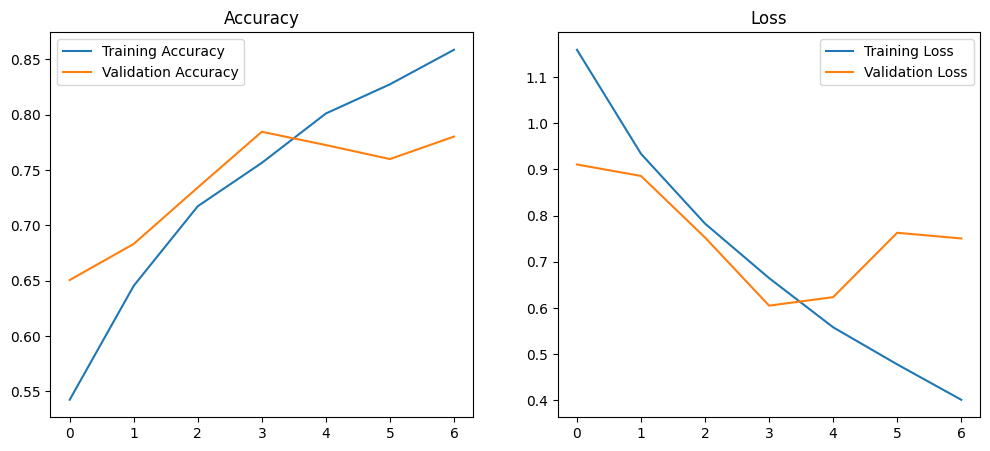

In [27]:
import matplotlib.pyplot as plt

# Récupérer les métriques de l'entraînement
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Tracer les courbes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [34]:
#confusion matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
# Obtenir les prédictions
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # prédictions : indices des classes
    y_true.extend(labels.numpy())            # vrais labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

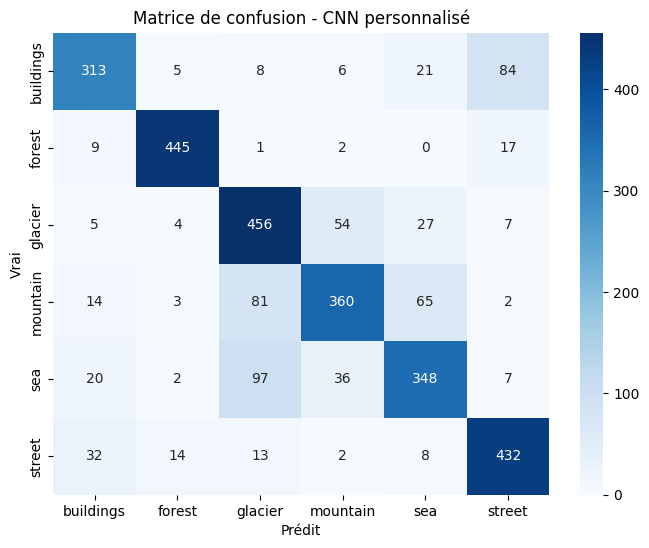

In [36]:
# Générer la matrice
cm = confusion_matrix(y_true, y_pred)

# Récupérer les noms des classes
class_names = test_class_names

# Afficher avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - CNN personnalisé")
plt.show()

# Le modèle CNN personnalisé obtient des performances solides sur certaines classes (ex. forêt, glacier),
# mais présente des confusions notables entre mer/glacier et buildings/street.
# Cela peut s'expliquer par des similarités visuelles (textures, teintes ou lignes de paysage).
# Une amélioration pourrait être obtenue par un modèle plus profond ou en utilisant le transfert learning


# Transfert Learning avec 2 modèles pré-entraînés TensorFlow

MobileNetV2 – Transfert Learning

In [69]:

from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(input_shape=(150, 150, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False  # On ne fine-tune pas encore

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 classes
])

<ipython-input-69-6f4c7b8e9cfa>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3),


In [44]:
model_mobilenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.7567 - loss: 0.6768 - val_accuracy: 0.8777 - val_loss: 0.3272
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8619 - loss: 0.3770 - val_accuracy: 0.8857 - val_loss: 0.3007
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.8786 - loss: 0.3353 - val_accuracy: 0.8760 - val_loss: 0.3362
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8922 - loss: 0.3018 - val_accuracy: 0.8887 - val_loss: 0.2961
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8960 - loss: 0.2748 - val_accuracy: 0.8933 - val_loss: 0.2827
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9066 - loss: 0.2504 - val_accuracy: 0.8833 - val_loss: 0.3246
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9131 - loss: 0.2296 - val_accuracy: 0.8897 - val_loss: 0.2975
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9200 - loss: 0.2053 - val_a

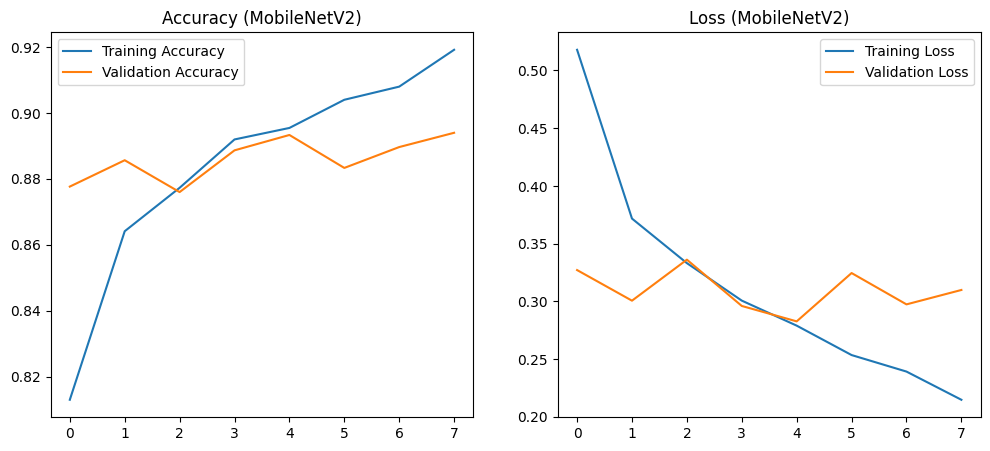

In [48]:
#Affichage des performances
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy (MobileNetV2)")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss (MobileNetV2)")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

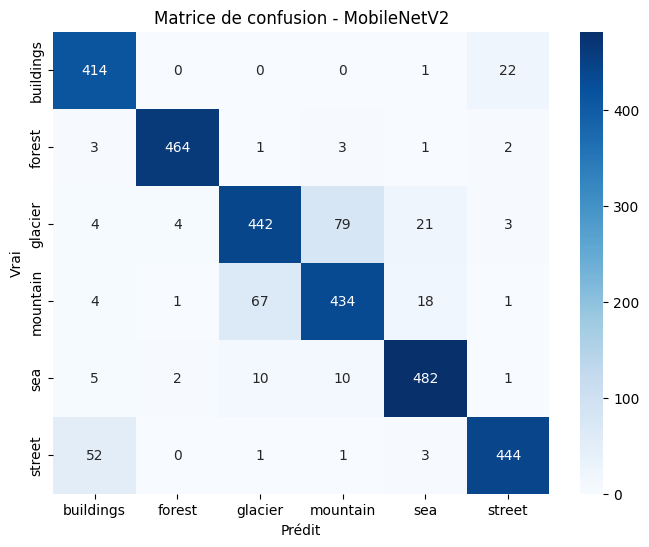

              precision    recall  f1-score   support

   buildings       0.86      0.95      0.90       437
      forest       0.99      0.98      0.98       474
     glacier       0.85      0.80      0.82       553
    mountain       0.82      0.83      0.83       525
         sea       0.92      0.95      0.93       510
      street       0.94      0.89      0.91       501

    accuracy                           0.89      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.89      0.89      0.89      3000



In [46]:
#Matrice de confusion
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model_mobilenet.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_class_names,
            yticklabels=test_class_names)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - MobileNetV2")
plt.show()

print(classification_report(y_true, y_pred, target_names=test_class_names))


EfficientNetB0

In [63]:

from tensorflow.keras.applications.efficientnet import preprocess_input

# Dataset avec preprocessing intégré
train_ds_effnet = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(150, 150),
    batch_size=32
).map(lambda x, y: (preprocess_input(x), y))

test_ds_effnet = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(150, 150),
    batch_size=32
).map(lambda x, y: (preprocess_input(x), y))


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [65]:
base_model = EfficientNetB0(input_shape=(150, 150, 3),
                            include_top=False,
                            weights='imagenet')
base_model.trainable = False

model_efficientnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])


In [66]:
model_efficientnet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_efficientnet = model_efficientnet.fit(
    train_ds_effnet,
    validation_data=test_ds_effnet,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 50s 64ms/step - accuracy: 0.8525 - loss: 0.4076 - val_accuracy: 0.9223 - val_loss: 0.2104
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.9293 - loss: 0.1914 - val_accuracy: 0.9233 - val_loss: 0.2151
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9347 - loss: 0.1714 - val_accuracy: 0.9270 - val_loss: 0.2110
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9444 - loss: 0.1470 - val_accuracy: 0.9270 - val_loss: 0.2088
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9501 - loss: 0.1315 - val_accuracy: 0.9277 - val_loss: 0.2127
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.9527 - loss: 0.1242 - val_accuracy: 0.9250 - val_loss: 0.2260
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9567 - loss: 0.1109 - val_accuracy: 0.9210 - val_loss: 0.2508


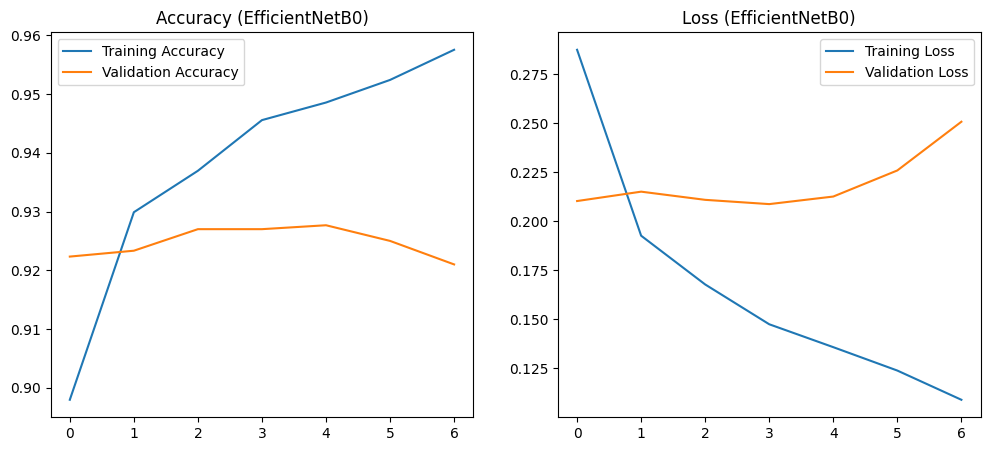

In [67]:
#Affichage des performances
acc = history_efficientnet.history['accuracy']
val_acc = history_efficientnet.history['val_accuracy']
loss = history_efficientnet.history['loss']
val_loss = history_efficientnet.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy (EfficientNetB0)")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss (EfficientNetB0)")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

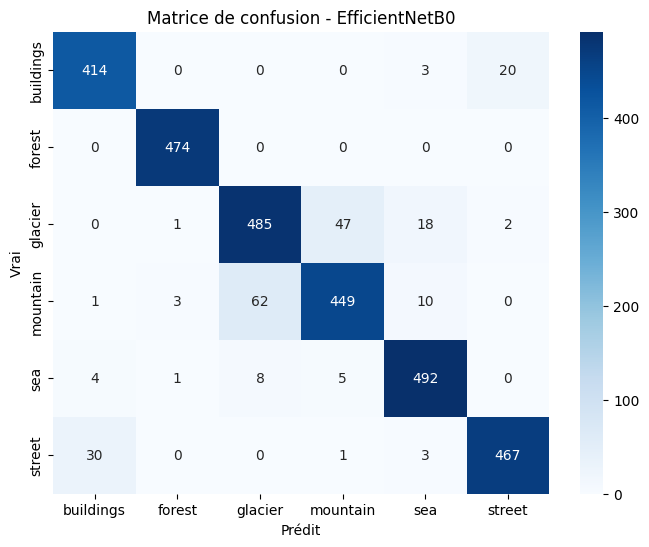

              precision    recall  f1-score   support

   buildings       0.92      0.95      0.93       437
      forest       0.99      1.00      0.99       474
     glacier       0.87      0.88      0.88       553
    mountain       0.89      0.86      0.87       525
         sea       0.94      0.96      0.95       510
      street       0.96      0.93      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



In [68]:
y_pred = []
y_true = []

for images, labels in test_ds_effnet:
    preds = model_efficientnet.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_class_names,
            yticklabels=test_class_names)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - EfficientNetB0")
plt.show()

print(classification_report(y_true, y_pred, target_names=test_class_names))


# Conclusion

Sur les trois modèles testés, EfficientNetB0 obtient les meilleures performances, avec une précision de validation de 92.2%, suivi de MobileNetV2 (88%) et du CNN personnalisé (78%). Ces résultats confirment l'efficacité du Transfert Learning pour des tâches de classification d'images, même sur un jeu de données équilibré comme celui utilisé.
Le choix final dépendra du compromis souhaité entre performance, temps d'entraînement et complexité du modèle.

streamlit

In [74]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [73]:
from google.colab import files
files.download("efficientnet_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
model.save("cnn_custom_model.keras")
model_mobilenet.save("mobilenetv2_model.keras")
model_efficientnet.save("efficientnet_model.keras")
